In [14]:
import pdb
import pycm
import sys
sys.path.append('../')
from glob import glob
import torch
import scipy
from torch import nn
import cv2
import os
# from models import Model
from PIL import Image
from skimage import io, transform
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from torchvision.datasets.folder import pil_loader
from torchvision import transforms
import random
import numpy as np
from torchsummary import summary
import pretrainedmodels
from sklearn.model_selection import KFold, StratifiedKFold
from efficientnet_pytorch import EfficientNet
import albumentations
from pycm import ConfusionMatrix
from tensorboard_logger import * 
import warnings
warnings.filterwarnings("ignore")
from models import *
import albumentations
from albumentations import torch as AT
#os.environ['CUDA_VISIBLE_DEVICES']=""

%matplotlib inline


#### PyCM testing

In [3]:
y_actual = [1, 2, 3, 4]
y_pred = [1, 1, 3, 2]
cm = ConfusionMatrix(y_actual, y_pred)

In [5]:
cm.qwk  = 1

In [7]:
cm.save_obj('test.obj', save_stat=True, save_vector=True)

{'Status': True,
 'Message': '/media/ags/DATA/CODE/kaggle/aptos2019-blindness-detection/notebooks/test.obj.obj'}

In [9]:
cm_loaded = ConfusionMatrix(file=open("test.obj.obj"))

In [17]:
cm_loaded.qwk


AttributeError: 'ConfusionMatrix' object has no attribute 'qwk'

In [23]:
test = open('test.obj.obj')
red = test.read()

In [25]:
import json
red = json.loads(red)

In [28]:
red['qwk']

KeyError: 'qwk'

ConfusionMatrix is not saving additional attributes, let's modify those which are already present

In [89]:

class CM(ConfusionMatrix):

    def __init__(
            self,
            *args):
        ConfusionMatrix.__init__(self,
            *args)
        
    def save(self,
             name,
             qwk=None,
             loss=None, 
             **kwargs):
        status = self.save_obj(name, **kwargs)
        obj_full_path = status['Message']
        print(obj_full_path)
        with open(obj_full_path, 'r') as f:
            dump_dict = json.load(f)
            dump_dict['Overall-Stat']['qwk'] = qwk
            dump_dict['Overall-Stat']['loss'] = loss
        json.dump(dump_dict, open(obj_full_path, 'w'))
 

In [90]:
y_actual = [1, 2, 3, 4]
y_pred = [1, 1, 3, 2]
cm = CM(y_actual, y_pred)

In [91]:
cm.save('test', qwk=1, loss=1, save_stat=True, save_vector=True)

/media/ags/DATA/CODE/kaggle/aptos2019-blindness-detection/notebooks/test.obj


In [95]:
f = open('test.obj', 'r')
data = json.load(f)

In [96]:
data

{'Actual-Vector': [1, 2, 3, 4],
 'Predict-Vector': [1, 1, 3, 2],
 'Matrix': [[1, [[1, 1], [2, 0], [3, 0], [4, 0]]],
  [2, [[1, 1], [2, 0], [3, 0], [4, 0]]],
  [3, [[1, 0], [2, 0], [3, 1], [4, 0]]],
  [4, [[1, 0], [2, 1], [3, 0], [4, 0]]]],
 'Digit': 5,
 'Sample-Weight': None,
 'Transpose': False,
 'Class-Stat': {'TPR': {'1': 1.0, '2': 0.0, '3': 1.0, '4': 0.0},
  'TNR': {'1': 0.6666666666666666,
   '2': 0.6666666666666666,
   '3': 1.0,
   '4': 1.0},
  'PPV': {'1': 0.5, '2': 0.0, '3': 1.0, '4': 'None'},
  'NPV': {'1': 1.0, '2': 0.6666666666666666, '3': 1.0, '4': 0.75},
  'FNR': {'1': 0.0, '2': 1.0, '3': 0.0, '4': 1.0},
  'FPR': {'1': 0.33333333333333337,
   '2': 0.33333333333333337,
   '3': 0.0,
   '4': 0.0},
  'FDR': {'1': 0.5, '2': 1.0, '3': 0.0, '4': 'None'},
  'FOR': {'1': 0.0, '2': 0.33333333333333337, '3': 0.0, '4': 0.25},
  'ACC': {'1': 0.75, '2': 0.5, '3': 1.0, '4': 0.75},
  'F1': {'1': 0.6666666666666666, '2': 0.0, '3': 1.0, '4': 0.0},
  'MCC': {'1': 0.5773502691896258,
   '2': 

In [87]:
data['qwk']

1

In [97]:

cm_loaded = ConfusionMatrix(file=open("test.obj"))

In [99]:
cm_loaded.overall_stat

{'Overall ACC': 0.5,
 'Kappa': 0.3333333333333333,
 'Overall RACC': 0.25,
 'SOA1(Landis & Koch)': 'Fair',
 'SOA2(Fleiss)': 'Poor',
 'SOA3(Altman)': 'Fair',
 'SOA4(Cicchetti)': 'Poor',
 'SOA5(Cramer)': 'None',
 'SOA6(Matthews)': 'Weak',
 'TPR Macro': 0.5,
 'PPV Macro': 'None',
 'ACC Macro': 0.75,
 'F1 Macro': 0.41666666666666663,
 'TPR Micro': 0.5,
 'PPV Micro': 0.5,
 'F1 Micro': 0.5,
 'Scott PI': 0.30434782608695654,
 'Gwet AC1': 0.3424657534246575,
 'Bennett S': 0.3333333333333333,
 'Kappa Standard Error': 0.3333333333333333,
 'Kappa 95% CI': (-0.32, 0.9866666666666666),
 'Chi-Squared': 'None',
 'Phi-Squared': 'None',
 'Cramer V': 'None',
 'Chi-Squared DF': 9,
 '95% CI': (0.010000000000000009, 0.99),
 'Standard Error': 0.25,
 'Response Entropy': 1.5,
 'Reference Entropy': 2.0,
 'Cross Entropy': 1.25,
 'Joint Entropy': 2.0,
 'Conditional Entropy': -0.0,
 'KL Divergence': 'None',
 'Lambda B': 1.0,
 'Lambda A': 0.6666666666666666,
 'Kappa Unbiased': 0.30434782608695654,
 'Overall RACCU':

It's has got some internal function which needs to be overwritten

In [42]:
cm.ERR  = 0

In [43]:

cm.save_obj('test', save_stat=True, save_vector=True)

{'Status': True,
 'Message': '/media/ags/DATA/CODE/kaggle/aptos2019-blindness-detection/notebooks/test.obj'}

In [44]:
cm_loaded = ConfusionMatrix(file=open("test.obj"))

In [45]:
cm_loaded.ERR

{1: 0.25, 2: 0.5, 3: 0.0, 4: 0.25}

Can't modify the values like this, it recalculates before saving

#### Rank averaging

In [22]:
# START
files = {}
files['file1'] = '../weights/submission785.csv'
files['file2'] = '../weights/submission796.csv'
files['file3'] = '../weights/submission77.csv'
# END


dfs = []
for key, _file in files.items():
    df = pd.read_csv(_file)
    df.rename(columns = {'diagnosis': key}, inplace=True)
    dfs.append(df)



_submission = pd.concat(dfs, axis=1)



In [23]:
_submission.head()

,id_code,file1,id_code,file2,id_code,file3
0,0005cfc8afb6,2,0005cfc8afb6,2,0005cfc8afb6,2
1,003f0afdcd15,3,003f0afdcd15,3,003f0afdcd15,2
2,006efc72b638,3,006efc72b638,2,006efc72b638,2
3,00836aaacf06,2,00836aaacf06,2,00836aaacf06,2
4,009245722fa4,3,009245722fa4,2,009245722fa4,2


In [24]:
a = _submission['file1']
a.rank?

In [25]:

for key in files.keys():
    _submission[key + '_rank'] = _submission[key].rank()



In [26]:
_submission.head()

,id_code,file1,id_code,file2,id_code,file3,file1_rank,file2_rank,file3_rank
0,0005cfc8afb6,2,0005cfc8afb6,2,0005cfc8afb6,2,1061.5,1075.0,1091.5
1,003f0afdcd15,3,003f0afdcd15,3,003f0afdcd15,2,1760.5,1765.5,1091.5
2,006efc72b638,3,006efc72b638,2,006efc72b638,2,1760.5,1075.0,1091.5
3,00836aaacf06,2,00836aaacf06,2,00836aaacf06,2,1061.5,1075.0,1091.5
4,009245722fa4,3,009245722fa4,2,009245722fa4,2,1760.5,1075.0,1091.5


In [27]:

_submission['rank_sum'] = np.sum(
        _submission[col] for col in _submission.columns if '_rank' in col)
_submission['target'] = _submission['rank_sum']/(len(files) *
        _submission.shape[0])

# take the first (id) and last column (target)
submission = _submission.iloc[:, [0, -1]]

In [28]:
_submission.head()

,id_code,file1,id_code,file2,id_code,file3,file1_rank,file2_rank,file3_rank,rank_sum,target
0,0005cfc8afb6,2,0005cfc8afb6,2,0005cfc8afb6,2,1061.5,1075.0,1091.5,3228.0,0.558091
1,003f0afdcd15,3,003f0afdcd15,3,003f0afdcd15,2,1760.5,1765.5,1091.5,4617.5,0.798323
2,006efc72b638,3,006efc72b638,2,006efc72b638,2,1760.5,1075.0,1091.5,3927.0,0.678942
3,00836aaacf06,2,00836aaacf06,2,00836aaacf06,2,1061.5,1075.0,1091.5,3228.0,0.558091
4,009245722fa4,3,009245722fa4,2,009245722fa4,2,1760.5,1075.0,1091.5,3927.0,0.678942


### Tesing EfficientNet

In [101]:
#torch.hub.load?

In [110]:
model = EfficientNet.from_name('efficientnet-b7')

In [111]:
summary(model, input_size=(3, 300, 300), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 301, 301]               0
Conv2dStaticSamePadding-2         [-1, 64, 150, 150]           1,728
       BatchNorm2d-3         [-1, 64, 150, 150]             128
         ZeroPad2d-4         [-1, 64, 152, 152]               0
Conv2dStaticSamePadding-5         [-1, 64, 150, 150]             576
       BatchNorm2d-6         [-1, 64, 150, 150]             128
          Identity-7             [-1, 64, 1, 1]               0
Conv2dStaticSamePadding-8             [-1, 16, 1, 1]           1,040
          Identity-9             [-1, 16, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 64, 1, 1]           1,088
         Identity-11         [-1, 64, 150, 150]               0
Conv2dStaticSamePadding-12         [-1, 32, 150, 150]           2,048
      BatchNorm2d-13         [-1, 32, 150, 150]              64
      MBConv

In [3]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=1)


Loaded pretrained weights for efficientnet-b5


In [6]:
def pytorch_count_params(model):
    from functools import reduce    
    "count number trainable parameters in a pytorch model"
    total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
    return total_params

In [7]:
pytorch_count_params(model)

28342833

In [44]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [2]:
a = 'asdf1234'

In [4]:
a.startswith('asd')

True

In [20]:
model = get_model('se_resnet50_v0')

In [25]:
model.model.features

<bound method SENet.features of SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNetBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
 

### test

In [2]:
df = pd.read_csv('../data/train_all.csv')

In [3]:
df.shape

(38788, 2)

In [5]:
df_mod = df.iloc[:5000]

In [6]:
df_mod.shape

(5000, 2)

## Activation maps, heatmaps, forward hooks, base model features

Processing...
Done!
Epoch 0, Batch idx 0, loss 0.7312949895858765
Epoch 0, Batch idx 1, loss 0.7278241515159607
Epoch 0, Batch idx 2, loss 0.7279630303382874
Epoch 0, Batch idx 3, loss 0.7259340286254883
Epoch 0, Batch idx 4, loss 0.7286208271980286
Epoch 0, Batch idx 5, loss 0.7284064292907715
Epoch 0, Batch idx 6, loss 0.7274430990219116
Epoch 0, Batch idx 7, loss 0.7257841229438782
Epoch 0, Batch idx 8, loss 0.7274317741394043
Epoch 0, Batch idx 9, loss 0.7263832688331604
Epoch 0, Batch idx 10, loss 0.7234258651733398
Epoch 0, Batch idx 11, loss 0.7221304178237915
Epoch 0, Batch idx 12, loss 0.7221720218658447
Epoch 0, Batch idx 13, loss 0.7226893901824951
Epoch 0, Batch idx 14, loss 0.7229772806167603
Epoch 0, Batch idx 15, loss 0.7233069539070129
Epoch 0, Batch idx 16, loss 0.7220962047576904
Epoch 0, Batch idx 17, loss 0.7201608419418335
Epoch 0, Batch idx 18, loss 0.7194996476173401
Epoch 0, Batch idx 19, loss 0.7206604480743408
Epoch 0, Batch idx 20, loss 0.7193939089775085
Epo

Epoch 0, Batch idx 190, loss 0.23959435522556305
Epoch 0, Batch idx 191, loss 0.27200010418891907
Epoch 0, Batch idx 192, loss 0.27440664172172546
Epoch 0, Batch idx 193, loss 0.24890342354774475
Epoch 0, Batch idx 194, loss 0.24767106771469116
Epoch 0, Batch idx 195, loss 0.2605665922164917
Epoch 0, Batch idx 196, loss 0.23970288038253784
Epoch 0, Batch idx 197, loss 0.2355841100215912
Epoch 0, Batch idx 198, loss 0.2277648150920868
Epoch 0, Batch idx 199, loss 0.2790812849998474
Epoch 0, Batch idx 200, loss 0.22580453753471375
Epoch 0, Batch idx 201, loss 0.24785669147968292
Epoch 0, Batch idx 202, loss 0.28680840134620667
Epoch 0, Batch idx 203, loss 0.24540609121322632
Epoch 0, Batch idx 204, loss 0.2505214810371399
Epoch 0, Batch idx 205, loss 0.25247830152511597
Epoch 0, Batch idx 206, loss 0.251901239156723
Epoch 0, Batch idx 207, loss 0.20644453167915344
Epoch 0, Batch idx 208, loss 0.2411489635705948
Epoch 0, Batch idx 209, loss 0.2308104932308197
Epoch 0, Batch idx 210, loss 

Epoch 0, Batch idx 404, loss 0.18505914509296417
Epoch 0, Batch idx 405, loss 0.18089300394058228
Epoch 0, Batch idx 406, loss 0.1719001680612564
Epoch 0, Batch idx 407, loss 0.20972469449043274
Epoch 0, Batch idx 408, loss 0.1896662563085556
Epoch 0, Batch idx 409, loss 0.15503093600273132
Epoch 0, Batch idx 410, loss 0.1884637326002121
Epoch 0, Batch idx 411, loss 0.1837373971939087
Epoch 0, Batch idx 412, loss 0.17539162933826447
Epoch 0, Batch idx 413, loss 0.17658284306526184
Epoch 0, Batch idx 414, loss 0.1696045994758606
Epoch 0, Batch idx 415, loss 0.17265109717845917
Epoch 0, Batch idx 416, loss 0.17170551419258118
Epoch 0, Batch idx 417, loss 0.1842697113752365
Epoch 0, Batch idx 418, loss 0.15941572189331055
Epoch 0, Batch idx 419, loss 0.17142513394355774
Epoch 0, Batch idx 420, loss 0.18070298433303833
Epoch 0, Batch idx 421, loss 0.16650550067424774
Epoch 0, Batch idx 422, loss 0.1726399064064026
Epoch 0, Batch idx 423, loss 0.16948769986629486
Epoch 0, Batch idx 424, los

Epoch 0, Batch idx 591, loss 0.13748201727867126
Epoch 0, Batch idx 592, loss 0.1656104177236557
Epoch 0, Batch idx 593, loss 0.15605340898036957
Epoch 0, Batch idx 594, loss 0.16795118153095245
Epoch 0, Batch idx 595, loss 0.16648876667022705
Epoch 0, Batch idx 596, loss 0.1626257598400116
Epoch 0, Batch idx 597, loss 0.14494407176971436
Epoch 0, Batch idx 598, loss 0.15935613214969635
Epoch 0, Batch idx 599, loss 0.17036455869674683
Epoch 0, Batch idx 600, loss 0.1688186526298523
Epoch 0, Batch idx 601, loss 0.15876507759094238
Epoch 0, Batch idx 602, loss 0.1780654937028885
Epoch 0, Batch idx 603, loss 0.16204197704792023
Epoch 0, Batch idx 604, loss 0.1463298350572586
Epoch 0, Batch idx 605, loss 0.15705084800720215
Epoch 0, Batch idx 606, loss 0.14525236189365387
Epoch 0, Batch idx 607, loss 0.16632485389709473
Epoch 0, Batch idx 608, loss 0.15000878274440765
Epoch 0, Batch idx 609, loss 0.14026470482349396
Epoch 0, Batch idx 610, loss 0.1270754486322403
Epoch 0, Batch idx 611, lo

Epoch 0, Batch idx 762, loss 0.1532663255929947
Epoch 0, Batch idx 763, loss 0.14967206120491028
Epoch 0, Batch idx 764, loss 0.16976144909858704
Epoch 0, Batch idx 765, loss 0.1617138534784317
Epoch 0, Batch idx 766, loss 0.16306304931640625
Epoch 0, Batch idx 767, loss 0.16062261164188385
Epoch 0, Batch idx 768, loss 0.14561960101127625
Epoch 0, Batch idx 769, loss 0.14488686621189117
Epoch 0, Batch idx 770, loss 0.16042397916316986
Epoch 0, Batch idx 771, loss 0.15346993505954742
Epoch 0, Batch idx 772, loss 0.15729248523712158
Epoch 0, Batch idx 773, loss 0.13600991666316986
Epoch 0, Batch idx 774, loss 0.16426478326320648
Epoch 0, Batch idx 775, loss 0.1494227647781372
Epoch 0, Batch idx 776, loss 0.16034728288650513
Epoch 0, Batch idx 777, loss 0.12533730268478394
Epoch 0, Batch idx 778, loss 0.16058751940727234
Epoch 0, Batch idx 779, loss 0.1368425041437149
Epoch 0, Batch idx 780, loss 0.15758846700191498
Epoch 0, Batch idx 781, loss 0.13885165750980377
Epoch 0, Batch idx 782, 

Epoch 0, Batch idx 939, loss 0.13828657567501068
Epoch 0, Batch idx 940, loss 0.13474930822849274
Epoch 0, Batch idx 941, loss 0.13532137870788574
Epoch 0, Batch idx 942, loss 0.13235482573509216
Epoch 0, Batch idx 943, loss 0.14146068692207336
Epoch 0, Batch idx 944, loss 0.15055005252361298
Epoch 0, Batch idx 945, loss 0.14229020476341248
Epoch 0, Batch idx 946, loss 0.14979368448257446
Epoch 0, Batch idx 947, loss 0.133245050907135
Epoch 0, Batch idx 948, loss 0.14272147417068481
Epoch 0, Batch idx 949, loss 0.15048500895500183
Epoch 0, Batch idx 950, loss 0.16222374141216278
Epoch 0, Batch idx 951, loss 0.13370363414287567
Epoch 0, Batch idx 952, loss 0.14857566356658936
Epoch 0, Batch idx 953, loss 0.15413415431976318
Epoch 0, Batch idx 954, loss 0.1476883441209793
Epoch 0, Batch idx 955, loss 0.15901553630828857
Epoch 0, Batch idx 956, loss 0.1302984356880188
Epoch 0, Batch idx 957, loss 0.13857485353946686
Epoch 0, Batch idx 958, loss 0.1483917385339737
Epoch 0, Batch idx 959, l

Epoch 0, Batch idx 1129, loss 0.1440870761871338
Epoch 0, Batch idx 1130, loss 0.14982545375823975
Epoch 0, Batch idx 1131, loss 0.14497056603431702
Epoch 0, Batch idx 1132, loss 0.12644349038600922
Epoch 0, Batch idx 1133, loss 0.13515856862068176
Epoch 0, Batch idx 1134, loss 0.14251577854156494
Epoch 0, Batch idx 1135, loss 0.1321851760149002
Epoch 0, Batch idx 1136, loss 0.1351611614227295
Epoch 0, Batch idx 1137, loss 0.13232190907001495
Epoch 0, Batch idx 1138, loss 0.1341869831085205
Epoch 0, Batch idx 1139, loss 0.14017334580421448
Epoch 0, Batch idx 1140, loss 0.12723320722579956
Epoch 0, Batch idx 1141, loss 0.13506321609020233
Epoch 0, Batch idx 1142, loss 0.1378396898508072
Epoch 0, Batch idx 1143, loss 0.13269051909446716
Epoch 0, Batch idx 1144, loss 0.1352870911359787
Epoch 0, Batch idx 1145, loss 0.13755357265472412
Epoch 0, Batch idx 1146, loss 0.13873696327209473
Epoch 0, Batch idx 1147, loss 0.12284937500953674
Epoch 0, Batch idx 1148, loss 0.13230259716510773
Epoch 

Epoch 0, Batch idx 1314, loss 0.12367089837789536
Epoch 0, Batch idx 1315, loss 0.1452738642692566
Epoch 0, Batch idx 1316, loss 0.12785322964191437
Epoch 0, Batch idx 1317, loss 0.1289137452840805
Epoch 0, Batch idx 1318, loss 0.13034866750240326
Epoch 0, Batch idx 1319, loss 0.14037130773067474
Epoch 0, Batch idx 1320, loss 0.13054277002811432
Epoch 0, Batch idx 1321, loss 0.13855528831481934
Epoch 0, Batch idx 1322, loss 0.10949265956878662
Epoch 0, Batch idx 1323, loss 0.1371050328016281
Epoch 0, Batch idx 1324, loss 0.14061817526817322
Epoch 0, Batch idx 1325, loss 0.1438538283109665
Epoch 0, Batch idx 1326, loss 0.1207302063703537
Epoch 0, Batch idx 1327, loss 0.13257282972335815
Epoch 0, Batch idx 1328, loss 0.12815749645233154
Epoch 0, Batch idx 1329, loss 0.12467329204082489
Epoch 0, Batch idx 1330, loss 0.121029794216156
Epoch 0, Batch idx 1331, loss 0.1498829573392868
Epoch 0, Batch idx 1332, loss 0.118963822722435
Epoch 0, Batch idx 1333, loss 0.12397880852222443
Epoch 0, B

Epoch 0, Batch idx 1502, loss 0.12206465005874634
Epoch 0, Batch idx 1503, loss 0.12036621570587158
Epoch 0, Batch idx 1504, loss 0.12229449301958084
Epoch 0, Batch idx 1505, loss 0.1023683175444603
Epoch 0, Batch idx 1506, loss 0.13230682909488678
Epoch 0, Batch idx 1507, loss 0.13498829305171967
Epoch 0, Batch idx 1508, loss 0.11505495756864548
Epoch 0, Batch idx 1509, loss 0.10706798732280731
Epoch 0, Batch idx 1510, loss 0.11409740895032883
Epoch 0, Batch idx 1511, loss 0.12841041386127472
Epoch 0, Batch idx 1512, loss 0.1286170780658722
Epoch 0, Batch idx 1513, loss 0.12940922379493713
Epoch 0, Batch idx 1514, loss 0.10623130202293396
Epoch 0, Batch idx 1515, loss 0.12019919604063034
Epoch 0, Batch idx 1516, loss 0.14774474501609802
Epoch 0, Batch idx 1517, loss 0.12955540418624878
Epoch 0, Batch idx 1518, loss 0.14244511723518372
Epoch 0, Batch idx 1519, loss 0.12463131546974182
Epoch 0, Batch idx 1520, loss 0.10560908913612366
Epoch 0, Batch idx 1521, loss 0.1276206076145172
Epo

Epoch 0, Batch idx 1678, loss 0.13216020166873932
Epoch 0, Batch idx 1679, loss 0.1254412680864334
Epoch 0, Batch idx 1680, loss 0.11154554039239883
Epoch 0, Batch idx 1681, loss 0.12909045815467834
Epoch 0, Batch idx 1682, loss 0.11611749976873398
Epoch 0, Batch idx 1683, loss 0.120845265686512
Epoch 0, Batch idx 1684, loss 0.13260821998119354
Epoch 0, Batch idx 1685, loss 0.12715522944927216
Epoch 0, Batch idx 1686, loss 0.1176399290561676
Epoch 0, Batch idx 1687, loss 0.12293808162212372
Epoch 0, Batch idx 1688, loss 0.10410350561141968
Epoch 0, Batch idx 1689, loss 0.12429586797952652
Epoch 0, Batch idx 1690, loss 0.1386018842458725
Epoch 0, Batch idx 1691, loss 0.11297985911369324
Epoch 0, Batch idx 1692, loss 0.13791492581367493
Epoch 0, Batch idx 1693, loss 0.11728789657354355
Epoch 0, Batch idx 1694, loss 0.12743130326271057
Epoch 0, Batch idx 1695, loss 0.10793479532003403
Epoch 0, Batch idx 1696, loss 0.12256540358066559
Epoch 0, Batch idx 1697, loss 0.12437330186367035
Epoch

Epoch 0, Batch idx 1865, loss 0.10921069234609604
Epoch 0, Batch idx 1866, loss 0.12408024072647095
Epoch 0, Batch idx 1867, loss 0.11673418432474136
Epoch 0, Batch idx 1868, loss 0.11228244006633759
Epoch 0, Batch idx 1869, loss 0.11631101369857788
Epoch 0, Batch idx 1870, loss 0.10446223616600037
Epoch 0, Batch idx 1871, loss 0.09909312427043915
Epoch 0, Batch idx 1872, loss 0.11620379239320755
Epoch 0, Batch idx 1873, loss 0.11487014591693878
Epoch 0, Batch idx 1874, loss 0.10956369340419769
Epoch 0, Batch idx 1875, loss 0.10891527682542801
Epoch 0, Batch idx 1876, loss 0.11098042130470276
Epoch 0, Batch idx 1877, loss 0.11303739994764328
Epoch 0, Batch idx 1878, loss 0.1212482675909996
Epoch 0, Batch idx 1879, loss 0.12134622782468796
Epoch 0, Batch idx 1880, loss 0.09944355487823486
Epoch 0, Batch idx 1881, loss 0.10171203315258026
Epoch 0, Batch idx 1882, loss 0.12423833459615707
Epoch 0, Batch idx 1883, loss 0.10474119335412979
Epoch 0, Batch idx 1884, loss 0.11834641546010971
E

Epoch 0, Batch idx 2055, loss 0.10763195902109146
Epoch 0, Batch idx 2056, loss 0.09405289590358734
Epoch 0, Batch idx 2057, loss 0.0967014878988266
Epoch 0, Batch idx 2058, loss 0.10023361444473267
Epoch 0, Batch idx 2059, loss 0.09543135017156601
Epoch 0, Batch idx 2060, loss 0.09648069739341736
Epoch 0, Batch idx 2061, loss 0.10694880038499832
Epoch 0, Batch idx 2062, loss 0.09568241983652115
Epoch 0, Batch idx 2063, loss 0.11135590076446533
Epoch 0, Batch idx 2064, loss 0.09095176309347153
Epoch 0, Batch idx 2065, loss 0.09788040071725845
Epoch 0, Batch idx 2066, loss 0.10000565648078918
Epoch 0, Batch idx 2067, loss 0.09571809321641922
Epoch 0, Batch idx 2068, loss 0.08931699395179749
Epoch 0, Batch idx 2069, loss 0.08758105337619781
Epoch 0, Batch idx 2070, loss 0.08563527464866638
Epoch 0, Batch idx 2071, loss 0.09643592685461044
Epoch 0, Batch idx 2072, loss 0.09497522562742233
Epoch 0, Batch idx 2073, loss 0.09816832095384598
Epoch 0, Batch idx 2074, loss 0.12239865958690643
E

Epoch 0, Batch idx 2245, loss 0.09197436273097992
Epoch 0, Batch idx 2246, loss 0.09760307520627975
Epoch 0, Batch idx 2247, loss 0.09645003080368042
Epoch 0, Batch idx 2248, loss 0.10475633293390274
Epoch 0, Batch idx 2249, loss 0.08425324410200119
Epoch 0, Batch idx 2250, loss 0.09547469764947891
Epoch 0, Batch idx 2251, loss 0.10019047558307648
Epoch 0, Batch idx 2252, loss 0.1056423932313919
Epoch 0, Batch idx 2253, loss 0.09783530980348587
Epoch 0, Batch idx 2254, loss 0.09195359796285629
Epoch 0, Batch idx 2255, loss 0.07188636064529419
Epoch 0, Batch idx 2256, loss 0.10450007766485214
Epoch 0, Batch idx 2257, loss 0.10302966088056564
Epoch 0, Batch idx 2258, loss 0.10114320367574692
Epoch 0, Batch idx 2259, loss 0.10366198420524597
Epoch 0, Batch idx 2260, loss 0.10620120167732239
Epoch 0, Batch idx 2261, loss 0.08470814675092697
Epoch 0, Batch idx 2262, loss 0.08579578995704651
Epoch 0, Batch idx 2263, loss 0.08683890104293823
Epoch 0, Batch idx 2264, loss 0.10651104152202606
E

Epoch 0, Batch idx 2427, loss 0.08050050586462021
Epoch 0, Batch idx 2428, loss 0.09773458540439606
Epoch 0, Batch idx 2429, loss 0.11987804621458054
Epoch 0, Batch idx 2430, loss 0.09788205474615097
Epoch 0, Batch idx 2431, loss 0.10258443653583527
Epoch 0, Batch idx 2432, loss 0.10602840781211853
Epoch 0, Batch idx 2433, loss 0.09323729574680328
Epoch 0, Batch idx 2434, loss 0.09701673686504364
Epoch 0, Batch idx 2435, loss 0.09169428050518036
Epoch 0, Batch idx 2436, loss 0.08550332486629486
Epoch 0, Batch idx 2437, loss 0.08976199477910995
Epoch 0, Batch idx 2438, loss 0.09980929642915726
Epoch 0, Batch idx 2439, loss 0.09387701749801636
Epoch 0, Batch idx 2440, loss 0.09563995152711868
Epoch 0, Batch idx 2441, loss 0.09997838735580444
Epoch 0, Batch idx 2442, loss 0.10582868754863739
Epoch 0, Batch idx 2443, loss 0.11721620708703995
Epoch 0, Batch idx 2444, loss 0.09368222951889038
Epoch 0, Batch idx 2445, loss 0.09906502813100815
Epoch 0, Batch idx 2446, loss 0.0868847593665123
E

Epoch 0, Batch idx 2608, loss 0.10134895145893097
Epoch 0, Batch idx 2609, loss 0.09129232913255692
Epoch 0, Batch idx 2610, loss 0.0898209810256958
Epoch 0, Batch idx 2611, loss 0.09433221071958542
Epoch 0, Batch idx 2612, loss 0.11377481371164322
Epoch 0, Batch idx 2613, loss 0.09920094162225723
Epoch 0, Batch idx 2614, loss 0.077652707695961
Epoch 0, Batch idx 2615, loss 0.10483410209417343
Epoch 0, Batch idx 2616, loss 0.12294533848762512
Epoch 0, Batch idx 2617, loss 0.10791145265102386
Epoch 0, Batch idx 2618, loss 0.08558988571166992
Epoch 0, Batch idx 2619, loss 0.07366596162319183
Epoch 0, Batch idx 2620, loss 0.088632732629776
Epoch 0, Batch idx 2621, loss 0.09295206516981125
Epoch 0, Batch idx 2622, loss 0.09544053673744202
Epoch 0, Batch idx 2623, loss 0.08386604487895966
Epoch 0, Batch idx 2624, loss 0.07064375281333923
Epoch 0, Batch idx 2625, loss 0.09665321558713913
Epoch 0, Batch idx 2626, loss 0.09011048078536987
Epoch 0, Batch idx 2627, loss 0.10235792398452759
Epoch

Epoch 0, Batch idx 2829, loss 0.10056568682193756
Epoch 0, Batch idx 2830, loss 0.10132789611816406
Epoch 0, Batch idx 2831, loss 0.08398358523845673
Epoch 0, Batch idx 2832, loss 0.10008666664361954
Epoch 0, Batch idx 2833, loss 0.06830082833766937
Epoch 0, Batch idx 2834, loss 0.08896110206842422
Epoch 0, Batch idx 2835, loss 0.09126914292573929
Epoch 0, Batch idx 2836, loss 0.09304879605770111
Epoch 0, Batch idx 2837, loss 0.08381415158510208
Epoch 0, Batch idx 2838, loss 0.09965994954109192
Epoch 0, Batch idx 2839, loss 0.09311209619045258
Epoch 0, Batch idx 2840, loss 0.09273847192525864
Epoch 0, Batch idx 2841, loss 0.0874849259853363
Epoch 0, Batch idx 2842, loss 0.09416484832763672
Epoch 0, Batch idx 2843, loss 0.09447085857391357
Epoch 0, Batch idx 2844, loss 0.08413336426019669
Epoch 0, Batch idx 2845, loss 0.09417501837015152
Epoch 0, Batch idx 2846, loss 0.10144796222448349
Epoch 0, Batch idx 2847, loss 0.08450895547866821
Epoch 0, Batch idx 2848, loss 0.09442214667797089
E

Epoch 0, Batch idx 3032, loss 0.09096136689186096
Epoch 0, Batch idx 3033, loss 0.0876278206706047
Epoch 0, Batch idx 3034, loss 0.09109615534543991
Epoch 0, Batch idx 3035, loss 0.10877367854118347
Epoch 0, Batch idx 3036, loss 0.09713801741600037
Epoch 0, Batch idx 3037, loss 0.08548019081354141
Epoch 0, Batch idx 3038, loss 0.08746254444122314
Epoch 0, Batch idx 3039, loss 0.08576858043670654
Epoch 0, Batch idx 3040, loss 0.09285201132297516
Epoch 0, Batch idx 3041, loss 0.10626175999641418
Epoch 0, Batch idx 3042, loss 0.11577949672937393
Epoch 0, Batch idx 3043, loss 0.09247968345880508
Epoch 0, Batch idx 3044, loss 0.09752635657787323
Epoch 0, Batch idx 3045, loss 0.0851089134812355
Epoch 0, Batch idx 3046, loss 0.08358360081911087
Epoch 0, Batch idx 3047, loss 0.08438039571046829
Epoch 0, Batch idx 3048, loss 0.10724693536758423
Epoch 0, Batch idx 3049, loss 0.10262203961610794
Epoch 0, Batch idx 3050, loss 0.09557440131902695
Epoch 0, Batch idx 3051, loss 0.07431501150131226
Ep

Epoch 0, Batch idx 3254, loss 0.08972729742527008
Epoch 0, Batch idx 3255, loss 0.09112675487995148
Epoch 0, Batch idx 3256, loss 0.08586221188306808
Epoch 0, Batch idx 3257, loss 0.09068920463323593
Epoch 0, Batch idx 3258, loss 0.10875729471445084
Epoch 0, Batch idx 3259, loss 0.09517687559127808
Epoch 0, Batch idx 3260, loss 0.08695657551288605
Epoch 0, Batch idx 3261, loss 0.08360643684864044
Epoch 0, Batch idx 3262, loss 0.09413295239210129
Epoch 0, Batch idx 3263, loss 0.07884007692337036
Epoch 0, Batch idx 3264, loss 0.08781620860099792
Epoch 0, Batch idx 3265, loss 0.07975819706916809
Epoch 0, Batch idx 3266, loss 0.0882960855960846
Epoch 0, Batch idx 3267, loss 0.08080609142780304
Epoch 0, Batch idx 3268, loss 0.10034212470054626
Epoch 0, Batch idx 3269, loss 0.09969128668308258
Epoch 0, Batch idx 3270, loss 0.08715002238750458
Epoch 0, Batch idx 3271, loss 0.08868283778429031
Epoch 0, Batch idx 3272, loss 0.09659512341022491
Epoch 0, Batch idx 3273, loss 0.10191036015748978
E

Epoch 0, Batch idx 3433, loss 0.09527625143527985
Epoch 0, Batch idx 3434, loss 0.08442064374685287
Epoch 0, Batch idx 3435, loss 0.08985431492328644
Epoch 0, Batch idx 3436, loss 0.08671001344919205
Epoch 0, Batch idx 3437, loss 0.08870691061019897
Epoch 0, Batch idx 3438, loss 0.0887591615319252
Epoch 0, Batch idx 3439, loss 0.07971695810556412
Epoch 0, Batch idx 3440, loss 0.07679497450590134
Epoch 0, Batch idx 3441, loss 0.08889512717723846
Epoch 0, Batch idx 3442, loss 0.08876179903745651
Epoch 0, Batch idx 3443, loss 0.10216861963272095
Epoch 0, Batch idx 3444, loss 0.10360541939735413
Epoch 0, Batch idx 3445, loss 0.09149417281150818
Epoch 0, Batch idx 3446, loss 0.10166943073272705
Epoch 0, Batch idx 3447, loss 0.07892964035272598
Epoch 0, Batch idx 3448, loss 0.10859549045562744
Epoch 0, Batch idx 3449, loss 0.08604389429092407
Epoch 0, Batch idx 3450, loss 0.09934297204017639
Epoch 0, Batch idx 3451, loss 0.08332567662000656
Epoch 0, Batch idx 3452, loss 0.09068137407302856
E

Epoch 0, Batch idx 3615, loss 0.09450238198041916
Epoch 0, Batch idx 3616, loss 0.08864013850688934
Epoch 0, Batch idx 3617, loss 0.08701377362012863
Epoch 0, Batch idx 3618, loss 0.08296719193458557
Epoch 0, Batch idx 3619, loss 0.08418010175228119
Epoch 0, Batch idx 3620, loss 0.0902961790561676
Epoch 0, Batch idx 3621, loss 0.09605405479669571
Epoch 0, Batch idx 3622, loss 0.07092079520225525
Epoch 0, Batch idx 3623, loss 0.08746150881052017
Epoch 0, Batch idx 3624, loss 0.09148740768432617
Epoch 0, Batch idx 3625, loss 0.08751195669174194
Epoch 0, Batch idx 3626, loss 0.08506537228822708
Epoch 0, Batch idx 3627, loss 0.10058877617120743
Epoch 0, Batch idx 3628, loss 0.08856099843978882
Epoch 0, Batch idx 3629, loss 0.10134489834308624
Epoch 0, Batch idx 3630, loss 0.0795220360159874
Epoch 0, Batch idx 3631, loss 0.09059019386768341
Epoch 0, Batch idx 3632, loss 0.09099506586790085
Epoch 0, Batch idx 3633, loss 0.08884987235069275
Epoch 0, Batch idx 3634, loss 0.08564440906047821
Ep

Epoch 0, Batch idx 3782, loss 0.084956094622612
Epoch 0, Batch idx 3783, loss 0.089450903236866
Epoch 0, Batch idx 3784, loss 0.09014911949634552
Epoch 0, Batch idx 3785, loss 0.08619483560323715
Epoch 0, Batch idx 3786, loss 0.09022268652915955
Epoch 0, Batch idx 3787, loss 0.08679033815860748
Epoch 0, Batch idx 3788, loss 0.08769907057285309
Epoch 0, Batch idx 3789, loss 0.0933559462428093
Epoch 0, Batch idx 3790, loss 0.09079097211360931
Epoch 0, Batch idx 3791, loss 0.07901109009981155
Epoch 0, Batch idx 3792, loss 0.09292933344841003
Epoch 0, Batch idx 3793, loss 0.09209776669740677
Epoch 0, Batch idx 3794, loss 0.07243233174085617
Epoch 0, Batch idx 3795, loss 0.08110316097736359
Epoch 0, Batch idx 3796, loss 0.09572713077068329
Epoch 0, Batch idx 3797, loss 0.09731686860322952
Epoch 0, Batch idx 3798, loss 0.10687831789255142
Epoch 0, Batch idx 3799, loss 0.08176811039447784
Epoch 0, Batch idx 3800, loss 0.08640021830797195
Epoch 0, Batch idx 3801, loss 0.09305308014154434
Epoch

Epoch 0, Batch idx 3990, loss 0.09083763509988785
Epoch 0, Batch idx 3991, loss 0.09147786349058151
Epoch 0, Batch idx 3992, loss 0.08864966034889221
Epoch 0, Batch idx 3993, loss 0.09758370369672775
Epoch 0, Batch idx 3994, loss 0.09419222176074982
Epoch 0, Batch idx 3995, loss 0.08077835291624069
Epoch 0, Batch idx 3996, loss 0.08830013871192932
Epoch 0, Batch idx 3997, loss 0.09153350442647934
Epoch 0, Batch idx 3998, loss 0.110947385430336
Epoch 0, Batch idx 3999, loss 0.09793847799301147
Epoch 0, Batch idx 4000, loss 0.10432234406471252
Epoch 0, Batch idx 4001, loss 0.09816327691078186
Epoch 0, Batch idx 4002, loss 0.09859113395214081
Epoch 0, Batch idx 4003, loss 0.09267984330654144
Epoch 0, Batch idx 4004, loss 0.07316642999649048
Epoch 0, Batch idx 4005, loss 0.10570535063743591
Epoch 0, Batch idx 4006, loss 0.0845351442694664
Epoch 0, Batch idx 4007, loss 0.09497317671775818
Epoch 0, Batch idx 4008, loss 0.0797068178653717
Epoch 0, Batch idx 4009, loss 0.08855831623077393
Epoc

Epoch 0, Batch idx 4209, loss 0.08257658779621124
Epoch 0, Batch idx 4210, loss 0.09762738645076752
Epoch 0, Batch idx 4211, loss 0.0986081138253212
Epoch 0, Batch idx 4212, loss 0.08445684611797333
Epoch 0, Batch idx 4213, loss 0.08396660536527634
Epoch 0, Batch idx 4214, loss 0.09308353811502457
Epoch 0, Batch idx 4215, loss 0.0943898856639862
Epoch 0, Batch idx 4216, loss 0.092975914478302
Epoch 0, Batch idx 4217, loss 0.06968382000923157
Epoch 0, Batch idx 4218, loss 0.0980827584862709
Epoch 0, Batch idx 4219, loss 0.09696369618177414
Epoch 0, Batch idx 4220, loss 0.09520973265171051
Epoch 0, Batch idx 4221, loss 0.06807922571897507
Epoch 0, Batch idx 4222, loss 0.10610873252153397
Epoch 0, Batch idx 4223, loss 0.10130143910646439
Epoch 0, Batch idx 4224, loss 0.07278578728437424
Epoch 0, Batch idx 4225, loss 0.09012889862060547
Epoch 0, Batch idx 4226, loss 0.10021406412124634
Epoch 0, Batch idx 4227, loss 0.0924583151936531
Epoch 0, Batch idx 4228, loss 0.10032660514116287
Epoch 

Epoch 0, Batch idx 4404, loss 0.08983412384986877
Epoch 0, Batch idx 4405, loss 0.08083202689886093
Epoch 0, Batch idx 4406, loss 0.09151194244623184
Epoch 0, Batch idx 4407, loss 0.08907008916139603
Epoch 0, Batch idx 4408, loss 0.08698679506778717
Epoch 0, Batch idx 4409, loss 0.07210200279951096
Epoch 0, Batch idx 4410, loss 0.08896326273679733
Epoch 0, Batch idx 4411, loss 0.09363368898630142
Epoch 0, Batch idx 4412, loss 0.08853808045387268
Epoch 0, Batch idx 4413, loss 0.0885414108633995
Epoch 0, Batch idx 4414, loss 0.08360651880502701
Epoch 0, Batch idx 4415, loss 0.09815572202205658
Epoch 0, Batch idx 4416, loss 0.07810133695602417
Epoch 0, Batch idx 4417, loss 0.08882278203964233
Epoch 0, Batch idx 4418, loss 0.0954585149884224
Epoch 0, Batch idx 4419, loss 0.09044259786605835
Epoch 0, Batch idx 4420, loss 0.08054552972316742
Epoch 0, Batch idx 4421, loss 0.06897511333227158
Epoch 0, Batch idx 4422, loss 0.10364685207605362
Epoch 0, Batch idx 4423, loss 0.0937674269080162
Epo

Epoch 0, Batch idx 4570, loss 0.09309173375368118
Epoch 0, Batch idx 4571, loss 0.08756261318922043
Epoch 0, Batch idx 4572, loss 0.08116743713617325
Epoch 0, Batch idx 4573, loss 0.09553806483745575
Epoch 0, Batch idx 4574, loss 0.0775541216135025
Epoch 0, Batch idx 4575, loss 0.07446615397930145
Epoch 0, Batch idx 4576, loss 0.0905323252081871
Epoch 0, Batch idx 4577, loss 0.08912601321935654
Epoch 0, Batch idx 4578, loss 0.0907728299498558
Epoch 0, Batch idx 4579, loss 0.10195951908826828
Epoch 0, Batch idx 4580, loss 0.07737519592046738
Epoch 0, Batch idx 4581, loss 0.08414846658706665
Epoch 0, Batch idx 4582, loss 0.08816748857498169
Epoch 0, Batch idx 4583, loss 0.08955337852239609
Epoch 0, Batch idx 4584, loss 0.09331356734037399
Epoch 0, Batch idx 4585, loss 0.08484821766614914
Epoch 0, Batch idx 4586, loss 0.0891956314444542
Epoch 0, Batch idx 4587, loss 0.08180972188711166
Epoch 0, Batch idx 4588, loss 0.09504079818725586
Epoch 0, Batch idx 4589, loss 0.08201951533555984
Epoc

Epoch 0, Batch idx 4768, loss 0.09202287346124649
Epoch 0, Batch idx 4769, loss 0.09942200779914856
Epoch 0, Batch idx 4770, loss 0.09871888905763626
Epoch 0, Batch idx 4771, loss 0.09672505408525467
Epoch 0, Batch idx 4772, loss 0.09714051336050034
Epoch 0, Batch idx 4773, loss 0.06412069499492645
Epoch 0, Batch idx 4774, loss 0.09075046330690384
Epoch 0, Batch idx 4775, loss 0.09345393627882004
Epoch 0, Batch idx 4776, loss 0.09568487107753754
Epoch 0, Batch idx 4777, loss 0.08553783595561981
Epoch 0, Batch idx 4778, loss 0.07621008157730103
Epoch 0, Batch idx 4779, loss 0.09260883182287216
Epoch 0, Batch idx 4780, loss 0.0867411345243454
Epoch 0, Batch idx 4781, loss 0.06643134355545044
Epoch 0, Batch idx 4782, loss 0.08717841655015945
Epoch 0, Batch idx 4783, loss 0.10195288062095642
Epoch 0, Batch idx 4784, loss 0.08607959002256393
Epoch 0, Batch idx 4785, loss 0.09619017690420151
Epoch 0, Batch idx 4786, loss 0.0801418349146843
Epoch 0, Batch idx 4787, loss 0.08146028965711594
Ep

Epoch 0, Batch idx 4938, loss 0.08940962702035904
Epoch 0, Batch idx 4939, loss 0.08074017614126205
Epoch 0, Batch idx 4940, loss 0.09616595506668091
Epoch 0, Batch idx 4941, loss 0.090206079185009
Epoch 0, Batch idx 4942, loss 0.09415555745363235
Epoch 0, Batch idx 4943, loss 0.09940099716186523
Epoch 0, Batch idx 4944, loss 0.09800161421298981
Epoch 0, Batch idx 4945, loss 0.09386918693780899
Epoch 0, Batch idx 4946, loss 0.0865447074174881
Epoch 0, Batch idx 4947, loss 0.08463230729103088
Epoch 0, Batch idx 4948, loss 0.09120982885360718
Epoch 0, Batch idx 4949, loss 0.07813501358032227
Epoch 0, Batch idx 4950, loss 0.09648686647415161
Epoch 0, Batch idx 4951, loss 0.08504374325275421
Epoch 0, Batch idx 4952, loss 0.09127002209424973
Epoch 0, Batch idx 4953, loss 0.09356111288070679
Epoch 0, Batch idx 4954, loss 0.08276215195655823
Epoch 0, Batch idx 4955, loss 0.09741684049367905
Epoch 0, Batch idx 4956, loss 0.09088878333568573
Epoch 0, Batch idx 4957, loss 0.08442765474319458
Epo

Epoch 0, Batch idx 5105, loss 0.08560969680547714
Epoch 0, Batch idx 5106, loss 0.07976534217596054
Epoch 0, Batch idx 5107, loss 0.0949554368853569
Epoch 0, Batch idx 5108, loss 0.09877939522266388
Epoch 0, Batch idx 5109, loss 0.08952698111534119
Epoch 0, Batch idx 5110, loss 0.09919983148574829
Epoch 0, Batch idx 5111, loss 0.108523428440094
Epoch 0, Batch idx 5112, loss 0.08693277835845947
Epoch 0, Batch idx 5113, loss 0.08590511232614517
Epoch 0, Batch idx 5114, loss 0.09563790261745453
Epoch 0, Batch idx 5115, loss 0.08305971324443817
Epoch 0, Batch idx 5116, loss 0.08215321600437164
Epoch 0, Batch idx 5117, loss 0.083612821996212
Epoch 0, Batch idx 5118, loss 0.07935686409473419
Epoch 0, Batch idx 5119, loss 0.07052534818649292
Epoch 0, Batch idx 5120, loss 0.08513052761554718
Epoch 0, Batch idx 5121, loss 0.08382152020931244
Epoch 0, Batch idx 5122, loss 0.07997778803110123
Epoch 0, Batch idx 5123, loss 0.08577792346477509
Epoch 0, Batch idx 5124, loss 0.09172490239143372
Epoch

Epoch 0, Batch idx 5279, loss 0.08321001380681992
Epoch 0, Batch idx 5280, loss 0.08933880180120468
Epoch 0, Batch idx 5281, loss 0.08573655039072037
Epoch 0, Batch idx 5282, loss 0.10126373916864395
Epoch 0, Batch idx 5283, loss 0.0785418376326561
Epoch 0, Batch idx 5284, loss 0.07943372428417206
Epoch 0, Batch idx 5285, loss 0.107582226395607
Epoch 0, Batch idx 5286, loss 0.09206873178482056
Epoch 0, Batch idx 5287, loss 0.07222010940313339
Epoch 0, Batch idx 5288, loss 0.09680402278900146
Epoch 0, Batch idx 5289, loss 0.08076424896717072
Epoch 0, Batch idx 5290, loss 0.07095952332019806
Epoch 0, Batch idx 5291, loss 0.08317942172288895
Epoch 0, Batch idx 5292, loss 0.08777150511741638
Epoch 0, Batch idx 5293, loss 0.09024003148078918
Epoch 0, Batch idx 5294, loss 0.09476698935031891
Epoch 0, Batch idx 5295, loss 0.06349173188209534
Epoch 0, Batch idx 5296, loss 0.1046115905046463
Epoch 0, Batch idx 5297, loss 0.10122073441743851
Epoch 0, Batch idx 5298, loss 0.08934033662080765
Epoc

Epoch 0, Batch idx 5445, loss 0.1008731871843338
Epoch 0, Batch idx 5446, loss 0.08322891592979431
Epoch 0, Batch idx 5447, loss 0.08405590057373047
Epoch 0, Batch idx 5448, loss 0.09654702991247177
Epoch 0, Batch idx 5449, loss 0.09164212644100189
Epoch 0, Batch idx 5450, loss 0.09308411926031113
Epoch 0, Batch idx 5451, loss 0.09509743750095367
Epoch 0, Batch idx 5452, loss 0.10236184298992157
Epoch 0, Batch idx 5453, loss 0.0726800188422203
Epoch 0, Batch idx 5454, loss 0.09497648477554321
Epoch 0, Batch idx 5455, loss 0.08337868750095367
Epoch 0, Batch idx 5456, loss 0.08005345612764359
Epoch 0, Batch idx 5457, loss 0.07447336614131927
Epoch 0, Batch idx 5458, loss 0.09325754642486572
Epoch 0, Batch idx 5459, loss 0.08961371332406998
Epoch 0, Batch idx 5460, loss 0.08929571509361267
Epoch 0, Batch idx 5461, loss 0.08123528957366943
Epoch 0, Batch idx 5462, loss 0.09642569720745087
Epoch 0, Batch idx 5463, loss 0.0874781683087349
Epoch 0, Batch idx 5464, loss 0.061052724719047546
Ep

Epoch 0, Batch idx 5640, loss 0.08134009689092636
Epoch 0, Batch idx 5641, loss 0.0888146311044693
Epoch 0, Batch idx 5642, loss 0.08999508619308472
Epoch 0, Batch idx 5643, loss 0.07396381348371506
Epoch 0, Batch idx 5644, loss 0.08079810440540314
Epoch 0, Batch idx 5645, loss 0.09148092567920685
Epoch 0, Batch idx 5646, loss 0.09683366864919662
Epoch 0, Batch idx 5647, loss 0.08546934276819229
Epoch 0, Batch idx 5648, loss 0.0913572683930397
Epoch 0, Batch idx 5649, loss 0.0828164741396904
Epoch 0, Batch idx 5650, loss 0.0777265653014183
Epoch 0, Batch idx 5651, loss 0.08728009462356567
Epoch 0, Batch idx 5652, loss 0.08896913379430771
Epoch 0, Batch idx 5653, loss 0.08435128629207611
Epoch 0, Batch idx 5654, loss 0.09571189433336258
Epoch 0, Batch idx 5655, loss 0.08432032912969589
Epoch 0, Batch idx 5656, loss 0.09642026573419571
Epoch 0, Batch idx 5657, loss 0.09585002809762955
Epoch 0, Batch idx 5658, loss 0.08831651508808136
Epoch 0, Batch idx 5659, loss 0.08082074671983719
Epoc

Epoch 0, Batch idx 5816, loss 0.07913830876350403
Epoch 0, Batch idx 5817, loss 0.07900022715330124
Epoch 0, Batch idx 5818, loss 0.08558401465415955
Epoch 0, Batch idx 5819, loss 0.0887511596083641
Epoch 0, Batch idx 5820, loss 0.07740394026041031
Epoch 0, Batch idx 5821, loss 0.09807273000478745
Epoch 0, Batch idx 5822, loss 0.08385317772626877
Epoch 0, Batch idx 5823, loss 0.09041014313697815
Epoch 0, Batch idx 5824, loss 0.08543358743190765
Epoch 0, Batch idx 5825, loss 0.07841720432043076
Epoch 0, Batch idx 5826, loss 0.09499707818031311
Epoch 0, Batch idx 5827, loss 0.09122687578201294
Epoch 0, Batch idx 5828, loss 0.10573715716600418
Epoch 0, Batch idx 5829, loss 0.08639859408140182
Epoch 0, Batch idx 5830, loss 0.07149789482355118
Epoch 0, Batch idx 5831, loss 0.08120830357074738
Epoch 0, Batch idx 5832, loss 0.0945638120174408
Epoch 0, Batch idx 5833, loss 0.08259745687246323
Epoch 0, Batch idx 5834, loss 0.08485409617424011
Epoch 0, Batch idx 5835, loss 0.07424329221248627
Ep

Epoch 0, Batch idx 5992, loss 0.08702307939529419
Epoch 0, Batch idx 5993, loss 0.0875362679362297
Epoch 0, Batch idx 5994, loss 0.08787998557090759
Epoch 0, Batch idx 5995, loss 0.09419966489076614
Epoch 0, Batch idx 5996, loss 0.07917232066392899
Epoch 0, Batch idx 5997, loss 0.09315261244773865
Epoch 0, Batch idx 5998, loss 0.08044672757387161
Epoch 0, Batch idx 5999, loss 0.0949433222413063
Epoch 0, Batch idx 6000, loss 0.07847338169813156
Epoch 0, Batch idx 6001, loss 0.0811750516295433
Epoch 0, Batch idx 6002, loss 0.0849020704627037
Epoch 0, Batch idx 6003, loss 0.08882176131010056
Epoch 0, Batch idx 6004, loss 0.08199574053287506
Epoch 0, Batch idx 6005, loss 0.08595829457044601
Epoch 0, Batch idx 6006, loss 0.10766594111919403
Epoch 0, Batch idx 6007, loss 0.07204035669565201
Epoch 0, Batch idx 6008, loss 0.08480476588010788
Epoch 0, Batch idx 6009, loss 0.08421319723129272
Epoch 0, Batch idx 6010, loss 0.06906933337450027
Epoch 0, Batch idx 6011, loss 0.1033967062830925
Epoch

Epoch 0, Batch idx 6210, loss 0.0908781960606575
Epoch 0, Batch idx 6211, loss 0.08229266107082367
Epoch 0, Batch idx 6212, loss 0.0917963758111
Epoch 0, Batch idx 6213, loss 0.09046312421560287
Epoch 0, Batch idx 6214, loss 0.08328253030776978
Epoch 0, Batch idx 6215, loss 0.09498849511146545
Epoch 0, Batch idx 6216, loss 0.08498984575271606
Epoch 0, Batch idx 6217, loss 0.07981252670288086
Epoch 0, Batch idx 6218, loss 0.09264790266752243
Epoch 0, Batch idx 6219, loss 0.0768754705786705
Epoch 0, Batch idx 6220, loss 0.08334938436746597
Epoch 0, Batch idx 6221, loss 0.08367634564638138
Epoch 0, Batch idx 6222, loss 0.0835687518119812
Epoch 0, Batch idx 6223, loss 0.08543695509433746
Epoch 0, Batch idx 6224, loss 0.08996821194887161
Epoch 0, Batch idx 6225, loss 0.08497796952724457
Epoch 0, Batch idx 6226, loss 0.11042075604200363
Epoch 0, Batch idx 6227, loss 0.09234046936035156
Epoch 0, Batch idx 6228, loss 0.07985920459032059
Epoch 0, Batch idx 6229, loss 0.08062982559204102
Epoch 0

Epoch 0, Batch idx 6416, loss 0.0895337387919426
Epoch 0, Batch idx 6417, loss 0.08074363321065903
Epoch 0, Batch idx 6418, loss 0.0786290392279625
Epoch 0, Batch idx 6419, loss 0.08587051182985306
Epoch 0, Batch idx 6420, loss 0.09422409534454346
Epoch 0, Batch idx 6421, loss 0.0843193307518959
Epoch 0, Batch idx 6422, loss 0.08970919251441956
Epoch 0, Batch idx 6423, loss 0.10229620337486267
Epoch 0, Batch idx 6424, loss 0.08738445490598679
Epoch 0, Batch idx 6425, loss 0.08966795355081558
Epoch 0, Batch idx 6426, loss 0.08077392727136612
Epoch 0, Batch idx 6427, loss 0.09699992835521698
Epoch 0, Batch idx 6428, loss 0.08633044362068176
Epoch 0, Batch idx 6429, loss 0.07494361698627472
Epoch 0, Batch idx 6430, loss 0.06940431147813797
Epoch 0, Batch idx 6431, loss 0.07087072730064392
Epoch 0, Batch idx 6432, loss 0.08499403297901154
Epoch 0, Batch idx 6433, loss 0.08915384113788605
Epoch 0, Batch idx 6434, loss 0.07936731725931168
Epoch 0, Batch idx 6435, loss 0.08297581225633621
Epo

Epoch 0, Batch idx 6632, loss 0.07073378562927246
Epoch 0, Batch idx 6633, loss 0.08154157549142838
Epoch 0, Batch idx 6634, loss 0.09135785698890686
Epoch 0, Batch idx 6635, loss 0.0874817967414856
Epoch 0, Batch idx 6636, loss 0.08910045027732849
Epoch 0, Batch idx 6637, loss 0.07526268064975739
Epoch 0, Batch idx 6638, loss 0.07893408089876175
Epoch 0, Batch idx 6639, loss 0.09447358548641205
Epoch 0, Batch idx 6640, loss 0.09088756889104843
Epoch 0, Batch idx 6641, loss 0.08317884057760239
Epoch 0, Batch idx 6642, loss 0.09425483644008636
Epoch 0, Batch idx 6643, loss 0.09774333238601685
Epoch 0, Batch idx 6644, loss 0.08202996850013733
Epoch 0, Batch idx 6645, loss 0.07833445072174072
Epoch 0, Batch idx 6646, loss 0.09802859276533127
Epoch 0, Batch idx 6647, loss 0.09919784218072891
Epoch 0, Batch idx 6648, loss 0.08725744485855103
Epoch 0, Batch idx 6649, loss 0.0979228988289833
Epoch 0, Batch idx 6650, loss 0.09084301441907883
Epoch 0, Batch idx 6651, loss 0.0875524953007698
Epo

Epoch 0, Batch idx 6802, loss 0.08603621274232864
Epoch 0, Batch idx 6803, loss 0.08549120277166367
Epoch 0, Batch idx 6804, loss 0.09133430570363998
Epoch 0, Batch idx 6805, loss 0.08360383659601212
Epoch 0, Batch idx 6806, loss 0.060804080218076706
Epoch 0, Batch idx 6807, loss 0.08738858252763748
Epoch 0, Batch idx 6808, loss 0.08540487289428711
Epoch 0, Batch idx 6809, loss 0.08624101430177689
Epoch 0, Batch idx 6810, loss 0.08640269935131073
Epoch 0, Batch idx 6811, loss 0.07662735879421234
Epoch 0, Batch idx 6812, loss 0.0766693726181984
Epoch 0, Batch idx 6813, loss 0.08926191926002502
Epoch 0, Batch idx 6814, loss 0.09153229743242264
Epoch 0, Batch idx 6815, loss 0.09420287609100342
Epoch 0, Batch idx 6816, loss 0.07634519040584564
Epoch 0, Batch idx 6817, loss 0.07929746806621552
Epoch 0, Batch idx 6818, loss 0.09330503642559052
Epoch 0, Batch idx 6819, loss 0.078196682035923
Epoch 0, Batch idx 6820, loss 0.07541190087795258
Epoch 0, Batch idx 6821, loss 0.09443481266498566
Ep

Epoch 0, Batch idx 6985, loss 0.07763781398534775
Epoch 0, Batch idx 6986, loss 0.07688276469707489
Epoch 0, Batch idx 6987, loss 0.09800955653190613
Epoch 0, Batch idx 6988, loss 0.08640909940004349
Epoch 0, Batch idx 6989, loss 0.08514410257339478
Epoch 0, Batch idx 6990, loss 0.09798309952020645
Epoch 0, Batch idx 6991, loss 0.0853763222694397
Epoch 0, Batch idx 6992, loss 0.09212882816791534
Epoch 0, Batch idx 6993, loss 0.08934679627418518
Epoch 0, Batch idx 6994, loss 0.10332945734262466
Epoch 0, Batch idx 6995, loss 0.09848228842020035
Epoch 0, Batch idx 6996, loss 0.09441099315881729
Epoch 0, Batch idx 6997, loss 0.07787222415208817
Epoch 0, Batch idx 6998, loss 0.07537240535020828
Epoch 0, Batch idx 6999, loss 0.08490197360515594
Epoch 0, Batch idx 7000, loss 0.09275980293750763
Epoch 0, Batch idx 7001, loss 0.09144076704978943
Epoch 0, Batch idx 7002, loss 0.08270561695098877
Epoch 0, Batch idx 7003, loss 0.09567062556743622
Epoch 0, Batch idx 7004, loss 0.07706842571496964
E

Epoch 0, Batch idx 7191, loss 0.06821312010288239
Epoch 0, Batch idx 7192, loss 0.08357340097427368
Epoch 0, Batch idx 7193, loss 0.0840001031756401
Epoch 0, Batch idx 7194, loss 0.09921881556510925
Epoch 0, Batch idx 7195, loss 0.07779700309038162
Epoch 0, Batch idx 7196, loss 0.10031779110431671
Epoch 0, Batch idx 7197, loss 0.09578363597393036
Epoch 0, Batch idx 7198, loss 0.08330294489860535
Epoch 0, Batch idx 7199, loss 0.09243215620517731
Epoch 0, Batch idx 7200, loss 0.08579771220684052
Epoch 0, Batch idx 7201, loss 0.09960879385471344
Epoch 0, Batch idx 7202, loss 0.07699551433324814
Epoch 0, Batch idx 7203, loss 0.09579174965620041
Epoch 0, Batch idx 7204, loss 0.0797264352440834
Epoch 0, Batch idx 7205, loss 0.09062843024730682
Epoch 0, Batch idx 7206, loss 0.08752810209989548
Epoch 0, Batch idx 7207, loss 0.08150181174278259
Epoch 0, Batch idx 7208, loss 0.07866596430540085
Epoch 0, Batch idx 7209, loss 0.08493643254041672
Epoch 0, Batch idx 7210, loss 0.0862654447555542
Epo

Epoch 0, Batch idx 7375, loss 0.09273229539394379
Epoch 0, Batch idx 7376, loss 0.09862914681434631
Epoch 0, Batch idx 7377, loss 0.08172166347503662
Epoch 0, Batch idx 7378, loss 0.08048487454652786
Epoch 0, Batch idx 7379, loss 0.10571849346160889
Epoch 0, Batch idx 7380, loss 0.09367937594652176
Epoch 0, Batch idx 7381, loss 0.08338391780853271
Epoch 0, Batch idx 7382, loss 0.07272662967443466
Epoch 0, Batch idx 7383, loss 0.0990479364991188
Epoch 0, Batch idx 7384, loss 0.08334934711456299
Epoch 0, Batch idx 7385, loss 0.07626327872276306
Epoch 0, Batch idx 7386, loss 0.08175799250602722
Epoch 0, Batch idx 7387, loss 0.07296231389045715
Epoch 0, Batch idx 7388, loss 0.07547349482774734
Epoch 0, Batch idx 7389, loss 0.09221483021974564
Epoch 0, Batch idx 7390, loss 0.09462150186300278
Epoch 0, Batch idx 7391, loss 0.07914288341999054
Epoch 0, Batch idx 7392, loss 0.09849317371845245
Epoch 0, Batch idx 7393, loss 0.09711507707834244
Epoch 0, Batch idx 7394, loss 0.08302707970142365
E

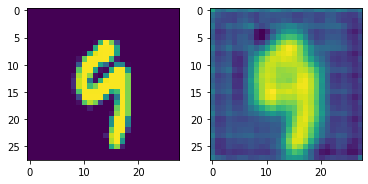

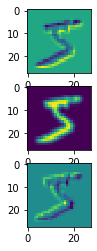

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

dataset = datasets.MNIST(
    root='PATH',
    transform=transforms.ToTensor(),
    download=True
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        print('Epoch {}, Batch idx {}, loss {}'.format(
            epoch, batch_idx, loss.item()))


def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img



In [24]:
output.shape, pred.shape

(torch.Size([1, 1, 28, 28]), torch.Size([28, 28]))

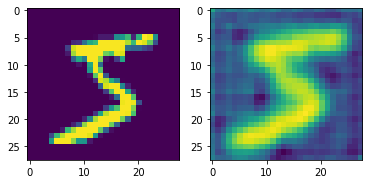

In [25]:
# Plot some images
idx = torch.randint(0, output.size(0), ())
pred = normalize_output(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())


In [26]:

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))


In [27]:

data, _ = dataset[0]
data.unsqueeze_(0)
output = model(data)

act = activation['conv1'].squeeze()


In [30]:
data.shape, output.shape, act.shape

(torch.Size([1, 1, 28, 28]),
 torch.Size([1, 1, 28, 28]),
 torch.Size([3, 28, 28]))

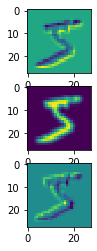

In [31]:
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

In [35]:
model_name = "densenet121"
model = Model(model_name, 5)

/home/ags/miniconda3/envs/ML/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [42]:
model.model.features.norm5.register_forward_hook(get_activation('norm5'))

In [43]:
#model.model.features.register_forward_hook()

In [52]:
img = torch.rand(1, 3, 224, 224)
output = model(img)
img.shape, output.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 5]))

In [53]:
act = activation['norm5'].squeeze()

In [54]:
act.shape

torch.Size([1024, 7, 7])

In [56]:
avg_act = torch.mean(act, 0)

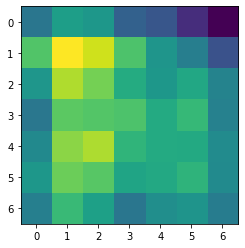

In [59]:

plt.imshow(avg_act)

In [4]:
scipy.optimize.minimize?

In [28]:
arr = np.array([[1, 1, 1, 1, 1], [1, 1, 0, 0, 0], [1, 0, 1, 1, 0], [0, 0, 0, 0, 0]])
mask = arr == 0
np.clip(np.where(mask.any(1), mask.argmax(1), 5) - 1, 0, 4)

array([4, 1, 0, 0])

In [19]:
mask

array([[False, False, False, False, False],
       [False, False,  True,  True,  True],
       [False,  True, False, False,  True],
       [ True,  True,  True,  True,  True]])

In [26]:
mask.any(1), mask.argmax(1) 

(array([False,  True,  True,  True]), array([0, 2, 1, 0]))

In [27]:
np.where(mask.any(1), mask.argmax(1), 5)

array([5, 2, 1, 0])

In [8]:
np.where?

In [3]:
target = [1, 2, 3, 4, 0, 1, 2, 3, 4]
NUM_CLASSES = 5
to_multi_label(target)

array([[1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]])

##  pycm analysis

In [3]:
from pycm import *
y_actu = [2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2] # or y_actu = numpy.array([2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2])
y_pred = [0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2] # or y_pred = numpy.array([0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2])
cm = ConfusionMatrix(actual_vector=y_actu, predict_vector=y_pred) # Create CM From Data

In [4]:
cm.ACC

{0: 0.8333333333333334, 1: 0.75, 2: 0.5833333333333334}

In [5]:
cm.stat()

Overall Statistics : 

95% CI                                                            (0.30439,0.86228)
ACC Macro                                                         0.72222
AUNP                                                              0.66667
AUNU                                                              0.69444
Bennett S                                                         0.375
CBA                                                               0.47778
Chi-Squared                                                       6.6
Chi-Squared DF                                                    4
Conditional Entropy                                               0.95915
Cramer V                                                          0.5244
Cross Entropy                                                     1.59352
F1 Macro                                                          0.56515
F1 Micro                                                          0.58333
Gwet AC1          

In [8]:
!ls

cm.csv.csv	   logs.md				    resnet_model.py
cm.csv_matrix.csv  models				    submission.py
cm.obj.obj	   models.py				    test.ipynb
data		   original_data			    todo.md
dataloader.py	   papers				    train.py
densenet.py	   params.json				    Untitled.ipynb
EDA2.ipynb	   __pycache__				    utils.py
EDA.ipynb	   pytorch-inference-kernel-lazy-tta.ipynb  weights
LICENSE		   README.md


In [18]:
cms = {}
cmfiles = glob('weights/5Jul_resnext101_32x4d_fold1/logs/*val*.obj')
for i in range(len(cmfiles)):
    cms[f"cm{i}"] = ConfusionMatrix(file=open(f"weights/5Jul_resnext101_32x4d_fold1/logs/cmval_{i}.obj","r"))

In [20]:
cp = Compare(cms)

In [21]:
print(cp)

Best : None

Rank                                            Name    Class-Score    Overall-Score
1                                               cm43    9.8            3.65
1                                               cm42    9.8            3.65
1                                               cm41    9.8            3.65
1                                               cm39    9.8            3.65
1                                               cm36    9.8            3.65
1                                               cm34    9.8            3.65
1                                               cm26    9.8            3.65
1                                               cm25    9.8            3.65
1                                               cm24    9.8            3.65
1                                               cm23    9.8            3.65
1                                               cm22    9.8            3.65
12                                              cm38    9.6       

In [40]:
cms['cm0'].overall_stat

Overall Statistics : 

95% CI                                                            (0.30439,0.86228)
ACC Macro                                                         0.72222
AUNP                                                              0.66667
AUNU                                                              0.69444
Bennett S                                                         0.375
CBA                                                               0.47778
Chi-Squared                                                       6.6
Chi-Squared DF                                                    4
Conditional Entropy                                               0.95915
Cramer V                                                          0.5244
Cross Entropy                                                     1.59352
F1 Macro                                                          0.56515
F1 Micro                                                          0.58333
Gwet AC1          

In [40]:
save_folder = "weights"
phase = "val"
val_logger = Logger(os.path.join(save_folder, "logs/val"),)
train_logger = Logger(os.path.join(save_folder, "logs/train"))
#configure( flush_secs=5)

In [41]:
metrics = ["Overall ACC", "Kappa", "TPR Micro", "PPV Micro", "F1 Micro", "Cross Entropy", ]
overall_stats = {x:[] for x in metrics}
for i in range(len(cmfiles)):
    for j in overall_stats.keys():
        overall_stats[j].append(cms["cm%d" % i].overall_stat[j])

In [42]:
def log_all(name, data_list, logger):
    for idx, val in enumerate(data_list):
        logger.log_value(name, val, idx)

In [44]:
for metric in metrics:
    log_all(metric, overall_stats[metric], val_logger)

In [23]:
a = torch.Tensor([[0, 0, 1], [1, 0, 0]])

In [28]:
torch.argmax(a, dim=1)

tensor([2, 0])

In [26]:
torch.argmax?

In [10]:
labels = [1, 0, 2, 3, 2, 3, 3, 3]
#np.eye(len(labels), 4)
#np.eye(4)[1]
len(np.unique(labels))kk

4

In [2]:
!ls data

sample_submission.csv  test  train  train_labels.csv


In [3]:
train_df = pd.read_csv('data/train_labels.csv')
test_df = pd.read_csv('data/sample_submission.csv')

In [4]:
test_df.shape

(57458, 2)

In [5]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
train_df.at[0, 'label'] = 1

In [7]:
kfold = StratifiedKFold(20, shuffle=True, random_state=69)

In [8]:
kfold.split(train_df['id'], train_df['label'])

<generator object _BaseKFold.split at 0x7fe662ddc8b8>

In [9]:
train_df.iloc[test]

NameError: name 'test' is not defined

In [10]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,1
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [11]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
id       220025 non-null object
label    220025 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
id       57458 non-null object
label    57458 non-null int64
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


(None, None)

In [12]:
%%time
img = mpimg.imread('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

CPU times: user 5.96 ms, sys: 0 ns, total: 5.96 ms
Wall time: 17.8 ms


In [13]:
timeit mpimg.imread('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

183 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
timeit pil_loader('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

In [ ]:
timeit cv2.imread('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif', flags=cv2.IMREAD_COLOR)

In [ ]:
timeit io.imread("data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif")

In [15]:
img = torch.Tensor(img)

In [17]:
img.flip?

In [18]:
torch.flip?

##### use cv2.imread for reading images 

In [ ]:
img.shape


In [ ]:
plt.imshow(img)

In [ ]:
# plot some random training images with their ground truth labels
i = random.choice(range(train_df.shape[0]))
img = mpimg.imread('data/train/' + train_df.iloc[i]['id'] + '.tif')
plt.imshow(img)
plt.title(train_df.iloc[i]['label'])
plt.show()

In [ ]:
train_df['label'].value_counts()

In [ ]:
train_df['label'].hist

In [ ]:
img = mpimg.imread('data/train/dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif')
plt.imshow(img)
plt.show();
aug_img = train_aug(image=img)
plt.imshow(aug_img['image'])
plt.show();

# Dataloader analysis


In [2]:
from dataloader import provider

In [3]:
fold =0
total_folds = 10
images_folder = '../data/train_png/'
df_path = '../data/train.csv'
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
dataloaders = {
    phase: provider(
        fold,
        total_folds, 
        images_folder,
        df_path,
        phase,
        size,
        mean,
        std,
        batch_size=1,
        num_workers=1,
    )
    for phase in ["train", "val"]
}

100%|██████████| 1159/1159 [00:00<00:00, 13924.31it/s]


In [66]:
files = []
for batch in dataloaders['train']:
    files.append(batch[0][0])

KeyboardInterrupt: 

In [13]:
val_files = []
for batch in dataloaders['val']:
    val_files.append(batch[0][0])

In [15]:
for f in val_files:
    if f in files:
        print(f)

this shows the sanctity of val set is not maintained

### analyse augmentations 

In [156]:
def get_transforms(phase, size, mean, std):
    list_transforms = [
        # albumentations.Resize(size, size) # now doing this in __getitem__()
        albumentations.Normalize(mean=mean, std=std, p=1),
    ]
    if phase == "train":
        list_transforms.extend(
            [
                albumentations.Transpose(p=0.5),
                albumentations.Flip(p=0.5),
                albumentations.ShiftScaleRotate(shift_limit=0, rotate_limit=120, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                albumentations.RandomBrightnessContrast(p=0.2),
            ]
        )

    list_transforms.extend(
        [
#             albumentations.Resize(size, size), # because RandomScale is applied
            AT.ToTensor(),
        ]
    )
    return albumentations.Compose(list_transforms)

In [157]:
phase = "train"
dataloader = dataloaders[phase]
dataloader.dataset.transform = get_transforms(phase, size, mean, std)

In [158]:
dataloader.dataset.transform.transforms

[Normalize(always_apply=False, p=1, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
 Transpose(always_apply=False, p=0.5),
 Flip(always_apply=False, p=0.5),
 ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0, 0), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-120, 120), interpolation=1, border_mode=0, value=None),
 RandomBrightnessContrast(always_apply=False, p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
 ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None)]

In [159]:
def unnormalize(img):
    mean = torch.as_tensor([0.485, 0.456, 0.406])
    std = torch.as_tensor([0.229, 0.224, 0.225])
    #return (img * std) + mean
    for t, m, s in zip(img, mean, std):    
        t.mul_(s).add_(m)
    return img

In [28]:
# plot some random training images with their ground truth labels
batch = next(iter(dataloader))
fnames, images, labels = batch
plt.figure(figsize=(15, 15))
#i = random.choice(range(len(images)))
i = 0 # as the batch size is 1
img = images[i].clone()
img = unnormalize(img)
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0));
plt.title(np.argmax(labels[i]).item())
plt.subplot(1, 2, 2)
#plt.imshow(mpimg.imread(f'../data/train_images/{fnames[i]}.png')); # original image
plt.imshow(np.load(f'../data/train_images/bgcc300/{fnames[i]}.npy')); # original image
plt.show(); 

NameError: name 'dataloader' is not defined

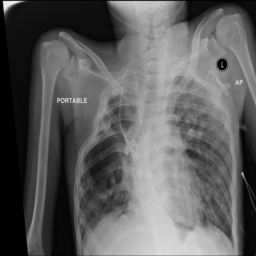

In [18]:
transforms.ToPILImage()(img)

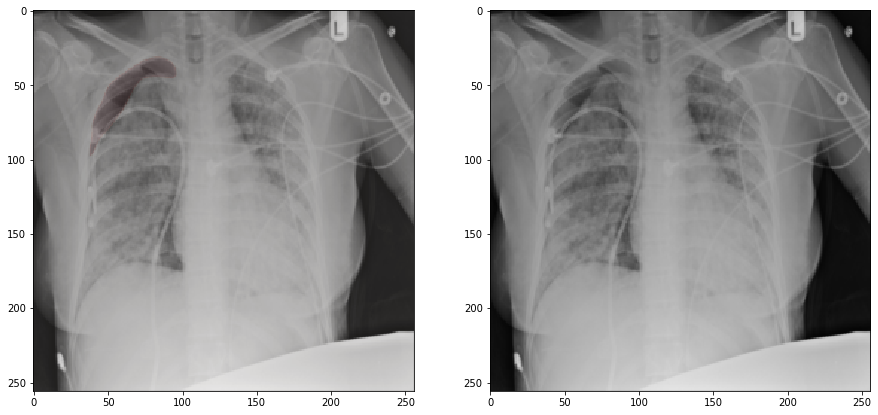

In [26]:
# plot some random training images with their ground truth labels
batch = next(iter(dataloaders['train']))
images, targets = batch
fnames = targets['image_id']
masks = targets['masks']
plt.figure(figsize=(15, 15))
#i = random.choice(range(len(images)))
i = 0 # as the batch size is 1
img = images[i].clone()
#img = img.permute(1, 2, 0)
mask = masks[i].clone()
mask = mask[0, :, :] # (1, size, size) -> (size, size)
#img = unnormalize(img)
plt.subplot(1, 2, 1)
#plt.imshow(img, cmap='bone');
plt.imshow(transforms.ToPILImage()(img), cmap='bone');
plt.imshow(mask, alpha=0.1, cmap='Reds')
plt.subplot(1, 2, 2)
#org_img = mpimg.imread(f'../data/train_png/{fnames[i]}.png')
org_img = Image.open(f'../data/train_png/{fnames[i]}.png').convert('RGB')
org_img = org_img.resize((size, size), resample=Image.BILINEAR)
plt.imshow(org_img, cmap='bone'); # original image
plt.show(); 

In [45]:
np.maximum?

#### augmentations testing

In [11]:
img = np.load('../data/train_images/npy_rgb/a00b4cb250a7.npy')

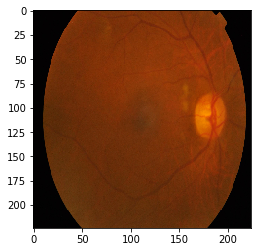

In [14]:
plt.imshow(img)

In [22]:
np.min(img), np.max(img)

(0, 255)

In [35]:
albumentations.Normalize # Divide pixel values by 255, subtract mean per channel and divide by std per channel

albumentations.augmentations.transforms.Normalize

In [28]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
norm = albumentations.Normalize(mean=mean, std=std, p=1)
norm_img = norm(image=img)['image']

In [33]:
np.min(norm_img), np.max(norm_img), norm_img[0, 0, 0]

(-2.117904, 2.2489083, -2.0665298)

In [37]:
norm_img.dtype

dtype('float32')

In [36]:
albumentations.torch.ToTensor? # convert image and mask to torch.Tensor and divide by 255 if image or mask are `uint8` type, use with care look into sources

In [39]:
albumentations.Normalize?

In [ ]:
mean = torch.as_tensor([0.485, 0.456, 0.406])
std = torch.as_tensor([0.229, 0.224, 0.225])
#return (img * std) + mean
#return img.mul_(std).add_(mean)
labels[i].item()

In [ ]:
mean, std, mean.shape, std.shape

### pretrained models testing

In [2]:
import pretrainedmodels
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [3]:
pretrainedmodels.pretrained_settings['resnext101_32x4d']

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/resnext101_32x4d-29e315fa.pth',
  'input_space': 'RGB',
  'input_size': [3, 224, 224],
  'input_range': [0, 1],
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'num_classes': 1000}}

In [7]:
summary(model2, input_size=(3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 512, 56, 56]          32,768
       BatchNorm2d-6          [-1, 512, 56, 56]           1,024
              ReLU-7          [-1, 512, 56, 56]               0
            Conv2d-8          [-1, 512, 56, 56]          73,728
       BatchNorm2d-9          [-1, 512, 56, 56]           1,024
             ReLU-10          [-1, 512, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         131,072
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [2]:
import torch
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl')

Using cache found in /home/ags/.cache/torch/hub/facebookresearch_WSL-Images_master


In [ ]:
model.fc

In [11]:
model.avgpool

AdaptiveAvgPool2d(output_size=(1, 1))

In [7]:
model.children()

<generator object Module.children at 0x7f7757651a98>

In [6]:
blocks = list(model.children())

In [9]:
backbone = nn.Sequential(
    *list(blocks[:-2])
) # upto AdaptiveAvgPool2d

In [10]:
backbone

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=

In [4]:
nn.AvgPool2d?

In [37]:
# model_name='se_resnext50_32x4d'
model_name= "resnext101_32x4d"#'nasnetamobile'
model_name = "resnet50"
#model_name = "densenet121"

model = pretrainedmodels.__dict__[model_name](num_classes=1000)

In [45]:
#list(model.children())
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [48]:
#model.features

In [5]:
# blocks = list(model.children())
# # blocks[:-3]
# model

In [32]:
blocks = list(model.children())
head = torch.nn.Sequential(*list(model.children())[:-3])
# model._modules['layer0'] = head
#model._modules['avg_pool'] = torch.nn.AvgPool2d(kernel_size=5, stride=1, padding=0) 
#model._modules['avg_pool'] = torch.nn.Sequential(*[torch.nn.ConstantPad2d((0,1,0,1), 0), torch.nn.AvgPool2d(kernel_size=7, stride=1, padding=0)])
# model._modules['avg_pool'] = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d((1, 1)))
# model._modules['last_linear'] = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
# model._modules['last_layer'] = classifier

In [12]:
torch.nn.AdaptiveAvgPool2d?

In [44]:
#head.parameters()
#for block in blocks:
base = list(blocks[0].children())[:-1] + blocks[1:-2]
torch.nn.Sequential(*base)
torch.nn.Dropout?
#    print(block)
#    print('*'*100)

In [46]:

torch.nn.Linear?

In [ ]:
#blocks[0] = head

In [ ]:
#blocks[-1] = torch.nn.Linear(in_features=2048, out_features=1, bias=True)

In [ ]:
#model = torch.nn.Sequential(*blocks)

In [ ]:
#model._modules

In [42]:
img = torch.Tensor(1, 3, 224, 224)#.to('cuda')
#img = torch.Tensor(1, 3, 112, 112)
#img = torch.Tensor(1, 3, 96, 96)

In [44]:
out = model(img)
features = model.features(img)
print(features.shape, out.shape)

torch.Size([1, 2048, 7, 7]) torch.Size([1, 1000])


In [19]:
nn.AdaptiveAvgPool2d((1, 1))(features).shape

torch.Size([1, 1024, 1, 1])

In [41]:
x = None
for param in model.features.children():
    
    print(param)
    if x is None:
        x = param(img)
    else:
        x = param(x)
    print(x.shape)

AttributeError: 'function' object has no attribute 'children'

In [30]:
# summary(model, input_size=(3, 96, 96))
# summary(model, input_size=(3, 112, 112))
summary(model.features, input_size=(3, 224, 224))

AttributeError: 'function' object has no attribute 'apply'

In [58]:
torch.nn.functional.max_pool2d
torch.nn.functional.adaptive_avg_pool2d?

In [32]:
# torch.nn.Dropout?

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)




In [34]:
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained="imagenet")
backbone = model.features
classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        Flatten(),
        nn.Dropout(0.5),
        nn.Linear(in_features=1056, out_features=1, bias=True)
        )



In [38]:
img = torch.Tensor(1, 3, 112, 112)
features = backbone(img)


RuntimeError: The size of tensor a (3) must match the size of tensor b (4) at non-singleton dimension 3

In [39]:
model.parameters()

<generator object Module.parameters at 0x7f961f946a20>

In [22]:
 
from albumentations import *

In [23]:
train_aug = Compose([
    Resize(224, 224),
    RandomRotate90(p=0.5),
    Transpose(p=0.5),
    Flip(p=0.5),
    OneOf([CLAHE(clip_limit=2), IAASharpen(), IAAEmboss(), RandomBrightnessContrast(), JpegCompression(), Blur(), GaussNoise() ], p=0.5), 
    HueSaturationValue(p=0.5), 
    ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=45, p=0.5),
    Normalize(p=1)
])
val_aug = Compose([
    Normalize(p=1)
])


In [24]:
ShiftScaleRotate?

In [25]:
Normalize?

In [ ]:
train_aug?

In [27]:
flip = Flip(p=1)

In [31]:
flip.apply?

##### AUC ROC

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainy)
# predict probabilities
probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = probs[:, 1]


In [ ]:
testy.shape, probs.shape

In [ ]:
fpr, tpr, thresholds

In [ ]:
# calculate AUC
auc = roc_auc_score(testy, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(testy, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [ ]:
pyplot.savefig('lol.png')

In [ ]:
pyplot.close('all')

In [47]:
import apex

In [48]:
apex.amp.?

In [2]:
import pandas as pd
df1 = pd.read_csv('weights/ensemble/11Mar_nasnetamobile_fold0_ckpt17.csv')
df2 = pd.read_csv('weights/ensemble/9Mar_se_resnext50_32x4d_v3_fold0_1_2_allckpt17.csv')
df3 = pd.read_csv('weights/ensemble/11Mar_nasnetamobile_v2_fold2_ckpt20.csv')
df= df1.copy()
df['label'] = (df1['label'] + df3['label'] + 3* df2['label'])/5

In [3]:
df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.027841
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.056335
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.001182
3,2c35657e312966e9294eac6841726ff3a748febf,0.005621
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.028158


In [5]:
df.to_csv('weights/ensemble/resnextfold012ckpt17+nasnetmobileckpt17+nasnetamobilefold2_ckpt20.csv', index=False)